# Lab 4: Standardized random variables, parameter estimation, confidence intervals

As usual, the first code cell below imports the packages we'll be using for this lab.

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy as sp
import scipy.stats as st
import pickle as pkl
print ("Modules Imported!")

Modules Imported!


Labs 1 and 3 go over most of the python that will be necessary for any of the labs, so there will be no more Python tutorial sections.  As you've probably noticed in previous labs, some questions may require more than just code. You can create new cells and designate their type as markdown in order to do this. I would suggest learning the basics of LaTex so that you can more easily represent your mathematical thought process. You can use LaTex syntax by placing it between two dollar signs in a markdown cell.

## Standardized Random Variables:

A standard random variable is one that has a mean of zero and a variance of one $(\mu=0, \sigma^2=1)$.  If a random variable $Y$ is not standard, then a standard one can be derived from it
by centering and linear rescaling.   The distribution (e.g. pmf) of the standardized version of $Y$ has the same shape as the distribution of $Y$.    We require two things of the standarized version: a mean of zero and a variance of one. If we let $X$ be the standardized form of $Y$ then $X = \frac{Y-\mu_Y}{\sigma_Y},$ where $\mu_Y$ is the mean of $Y$ and $\sigma_Y^2$ is the variance of $Y.$ Let's check this:
\begin{align*}
E[X] & = E\left[\frac{Y-\mu_Y}{\sigma_Y}\right] = \frac{1}{\sigma_y}E[Y-\mu_Y] = \frac{1}{\sigma_Y}(E[Y]-\mu_Y) = 0  \\
\mbox{Var}(X) & = \mbox{Var}\left(\frac{Y-\mu_Y}{\sigma_Y}\right) = \frac{1}{\sigma_Y^2}\mbox{Var}(Y-\mu_Y) = \frac{\mbox{Var}(Y)}{\sigma_Y^2} = 1
\end{align*}

So to standardize any random variable, we simply need to subtract the mean and then divide by the standard deviation. This is useful because if we know the CDF of a standardized version of a random variable we can find the CDF of the original version. For example, suppose $Y$ is a non-standard variable and $X$ is the standardized version of Y, and suppose we want to determine the CDF of Y but only have the CDF of X. We can determine the CDF by the following:

$F_Y(c) = P\{Y \le c\} = P\{Y-\mu_Y \le c-\mu_y\} = P\left\{\frac{Y-\mu_Y}{\sigma_Y} \le \frac{c-\mu_Y}{\sigma_Y}\right\}= P\left\{X \le \frac{c-\mu_Y}{\sigma_Y}\right\}$

Since Python does such a nice job of packaging these distributions, this isn't particularly necessary for our coding purposes. However, when you get to Gaussian distributions in your probability class, you will use this extensively.

$\textbf{Caveat}$: When you do problem 1, be aware of a machine-dependent feature of the .pmf method of a distribution object created by st.rv_discrete, which has caused bugs and confusion for many students before (especially in part 3). The .pmf behaves weirdly for non-integer values, illustrated this example: 

In [109]:
c = [1.5, 2.0]
p = [0.5, 0.5]
Z = st.rv_discrete(values=(c,p))
print (Z.pmf(2.0))  # Prints 0.5
print (Z.pmf(1.5))  # Prints 0.5 on some machines, Prints 0.0 on some other machines (e.g. your laptops)

0.5
0.0


This seems to be a design flaw of the scipy library. You are not required to understand it or fix it. Our suggestion is: please avoid using the .pmf method for non-integer values. -- Zeyu Zhou, Feb 2018

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 1:</SPAN>**  To illustrate the standardization procedure, 
<ol>
    <li> Select any discrete probability distribution for a random variable $Y$ such that $Y$ is NOT standard and the number of possible values of $Y$ is at least four.  
    <li> Create another random variable $X$, which is a standardized version of $Y$.
    <li> Plot the pmf of $Y$ and the pmf of $X.$   Up to centering and linear scaling, the pmfs should have the same shape. 
</ol>

(Hint: One way to do this problem is to use st.rv_discrete(values=(c,p)) for some vectors c and p as in Lab 1 to create Y, and then create $X$ by using a modification of (c,p). As we saw in Lab 1, if you plot pmfs using np.linspace, care must be taken so that the grid points at which the pmf is plotted includes all values that have positive probability.)

[-5. -3. -1.  1.]


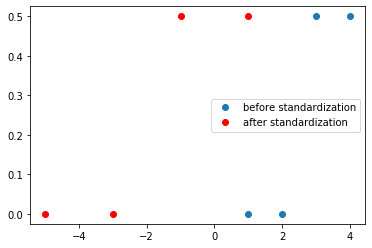

In [110]:
# Your code here
c = [1.,2.,3.,4.]
p = [0.0,0.0,0.5,0.5]
Y = st.rv_discrete(values=(c,p))

cx = (c-Y.mean())/ np.sqrt(Y.var())
print(cx)
X = st.rv_discrete(values=(cx,p))

plt.plot(c,Y.pmf(c), 'o', label = 'before standardization')
plt.plot(cx,X.pmf(cx), 'ro', label = 'after standardization')
plt.legend()

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 1</SPAN>**

## Parameter Estimation:

#### Maximum Likelihood Estimation (ML)

In statistics, sometimes we have data which we know follows a certain distribution, yet we don't know all of the parameters of that distribution. We want to use our observations to determine an estimate for the unknown parameters. For example, let's say that we know an experiment is accurately modeled by the random variable $X$ and that $X$ has some parameter $\theta$ which is unknown when the experiment is performed. During the experiment, we observe a particular value $k$ as a variate of $X$. The probability of us observing $k$ would be $p_{X,\theta}(k)$ where $p_{X,\theta}(k)$ is the pmf of $X$ and is dependent on $\theta$.  We call this the "likelihood that $X=k$". One common way to estimate parameter $\theta$ is with the <I> maximum likelihood estimator,</I> $\hat{\theta}_{ML},$ which is the value of $\theta$ that maximizes the likelihood $p_{X,\theta}(k)$ with respect to $\theta$.

$\hat{\theta}_{ML}(k) = argmax_{\theta} \ p_{X,\theta}(k)$

As an example to let's look at the Poisson distribution. We're conducting an experiment and we know that the result $X$ should have a Poisson distribution. The Poisson distribution has one parameter $\lambda$ which is unknown to us during the experiment and this is the parameter we want to estimate. We perform one experiment and the result is $k$. What's the best approximation for $\lambda$? From our formula above, we want to find:

$\hat{\lambda}_{ML}(k) = argmax_\lambda \ p_{X,\lambda}(k) = argmax_\lambda
\ \frac{e^{-\lambda}\lambda^k}{k!}$

Finding the argument, $\lambda$, that maximizes this expression is just simple calculus.

$\frac{dp_{X,\lambda}(k)}{d\lambda}= 0 = (k-\lambda)\frac{e^{-\lambda}\lambda^{k-1}}{k!}$

Since $e^{-\lambda}\lambda^k$ is going to be a positive value the only way to have this be zero is if  $\hat{\lambda}_{ML}=k$. If you were to check the second derivative, you would find that this is indeed a maximum. This makes sense intuitively. After a single experiment, we have a value $k$ and want to estimate $\lambda$ from it. The maximum likelihood of us having gotten $k$ in our single experiment would be achieved if $\lambda$ is equal to $k$.

We can confirm the above calculations by finding the ML estimate numerically with python. For more complicated problems,numerical calculation of the ML estimate might be the only option.   We want to find $argmax_\lambda \ p_{X,\lambda}(k)$. Rather than writing our own optimization method we can use the scipy.optimize.fmin() function. It finds the minimum of a function given an initial guess. There is no maximization function since maximizing is equivalent to minimizing the negative. The function returns a local minima, not necessarily a global minimum, so there is no guarantee that we will get the answer we're looking for, but if our initial guess is reasonable, we should be ok. Below is an example of how we can use this function with the Poisson distribution. We know X has a Poisson distribution and we want to estimate $\lambda$ given that we have observed $k=4$. 

Optimization terminated successfully.
         Current function value: -0.195367
         Iterations: 18
         Function evaluations: 36
[4.]


Text(0.5, 0, '$\\lambda$')

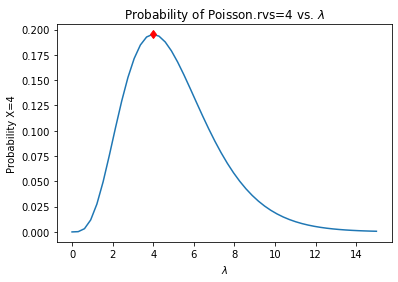

In [111]:
k = 4 #Observed Value of X
f = lambda x: -(np.e**-x)*(x**k)/np.math.factorial(k) #The negative pmf of X (since we are minimizing)
p_min = sp.optimize.fmin(f, 2); #Calls the optimization function with an initial guess at 2

print (p_min)
x = np.linspace(0,15) # default number of points is 50
plt.plot(x,-f(x)) #Plots the pmf as a function of lambda
plt.plot(p_min,-f(p_min), 'rd')
plt.title('Probability of Poisson.rvs=4 vs. $\lambda$')
plt.ylabel('Probability X='+str(k))
plt.xlabel('$\lambda$')

Just as we expected, the function is maximized when $\lambda = k$. 

Consider another scenario.  Suppose that we're flipping an unfair coin and keeping track of the number of heads we get. Suppose we've determined from separate mass calculations that the probability of heads is $p=\frac{1}{3}$. In our experiment we found that there were 49 heads, but we forgot how many times we flipped the coin. What is $\hat n_{ML},$ the maximum likelihood estimate of the number of flips? Clearly this can be modeled as $X \sim Binomial(n,\frac{1}{3})$ where we want to estimate $n$ based on our observation of 49 heads. Intuitively, it should make sense that the best estimate of $n$ would be $\frac{49}{\frac{1}{3}}=147$ coin flips. Ideally we will get the same answer from the ML method.  In more complicated problems there might not be an
"obvious" or "intuitive" answer, but we can still numerically calculate the ML estimator.
By definition, we have:

$\hat n_{ML} = argmax_n ~ p_{X,n}(49) = argmax_n \ \dbinom{n}{49}(\frac{1}{3})^{49}(1-\frac{1}{3})^{n-49}$

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 2:</SPAN>** The maximization is over the
discrete variable $n$, so we cannot use scipy.optimize method. <br> <ol>
<li> Calculate $\hat n_{ML}$ numerically using the brute force method.  That is, plot the likelihoods $p_{X,n}(49)$ versus n and print which $n$ maximizes the likelihood. Does it match our intuition? It may help to use the sp.special.binom() method for binomial coefficients.
<li> Another way to find the maximizer is to examine the ratios
$r(n) = p_{X,n}(49)/p_{X,n-1}(49)$ for different $n.$  Calculate and print these ratios for $130 \leq n \leq 170.$  How is the value $\hat n_{ML}$ indicated?

the result is 147.0


Text(0.5, 0, 'number flipping coins')

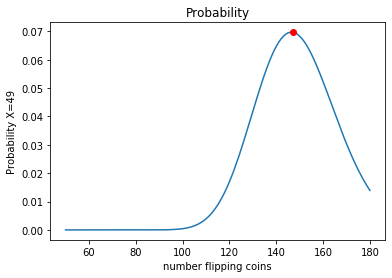

In [112]:
##### Your code here (add additional code/markdown cells if necessary)
p = 1./3
k = 49
#f = lambda n: -np.math.factorial(n)/np.math.factorial(k)/np.math.factorial(n-k) * (p)**k * (1-p)**(n-k)
#p_min = sp.optimize.fmin(f, 160)
#print (p_min)
n = np.linspace(50,180,131) 
res = sp.special.binom(n,k)* (p)**k * (1-p)**(n-k)
for i in range(1,len(res)-1):
    #print(i,res[i])
    if (res[i]-res[i+1])>=0 and (res[i]-res[i-1])>=0:
        max_i = i
print("the result is",n[max_i])
plt.plot(n,res, n[max_i], res[max_i], "ro")

plt.title('Probability')
plt.ylabel('Probability X='+str(k))
plt.xlabel('number flipping coins')

In [113]:
n = np.linspace(50,180,131)
f = lambda n: np.math.factorial(n)/np.math.factorial(k)/np.math.factorial(n-k) * (p)**k * (1-p)**(n-k)

for i in range(130,171):
    r = f(i)/f(i-1)
    print("n=",i, "; r=",r)

n= 130 ; r= 1.0699588477366258
n= 131 ; r= 1.065040650406504
n= 132 ; r= 1.060240963855422
n= 133 ; r= 1.0555555555555558
n= 134 ; r= 1.050980392156863
n= 135 ; r= 1.0465116279069766
n= 136 ; r= 1.042145593869732
n= 137 ; r= 1.0378787878787885
n= 138 ; r= 1.0337078651685392
n= 139 ; r= 1.0296296296296295
n= 140 ; r= 1.025641025641026
n= 141 ; r= 1.0217391304347827
n= 142 ; r= 1.017921146953405
n= 143 ; r= 1.0141843971631208
n= 144 ; r= 1.0105263157894735
n= 145 ; r= 1.0069444444444446
n= 146 ; r= 1.0034364261168387
n= 147 ; r= 0.9999999999999998
n= 148 ; r= 0.996632996632997
n= 149 ; r= 0.9933333333333336
n= 150 ; r= 0.9900990099009899
n= 151 ; r= 0.9869281045751637
n= 152 ; r= 0.9838187702265374
n= 153 ; r= 0.9807692307692306
n= 154 ; r= 0.9777777777777779
n= 155 ; r= 0.9748427672955976
n= 156 ; r= 0.9719626168224299
n= 157 ; r= 0.9691358024691361
n= 158 ; r= 0.9663608562691132
n= 159 ; r= 0.9636363636363636
n= 160 ; r= 0.9609609609609612
n= 161 ; r= 0.9583333333333334
n= 162 ; r= 0.9

__Answer:__ (Your answer here)
Yes, it match our intuitionthe value. $\hat n_{ML}$ indicates that when we've determined from separate mass calculations that the probability of heads is $p=\frac{1}{3}$, and in our experiment we found that there were 49 heads, then it has the largest probability that we flipped the coin 147 times in all.

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 2</SPAN>**

#### Maximum A Posteriori Probability (MAP)

The MAP estimator is a form of Bayes Estimation where the objective is to maximize the probability that the estimator is equal, or nearly equal, to the true parameter value. Suppose again that we're conducting an experiment and we know $X$ has some particular distribution but with an unknown parameter value $\Theta$. For the MAP estimator, we view the parameter as being random, which is why we've switched to using an upper case letter for it.  Viewing the parameter $\Theta$ as a
random variable requires us to assign a prior probability distribution to it. Here, "prior" means the distribution before any observations are known.   We use Bayes formula to then caculate the conditional distribution (i.e. the posterior distribution) of $\Theta$ given the observation. In ECE 313 MAP decision rules are discussed for binary hypothesis testing.  The same principle is used here for parameter estimation.   The result is that the MAP estimator is given by:
\begin{align*}
\widehat{\Theta}_{MAP}(k) & = argmax_\theta  P(\Theta = \theta | X=k )  \\
&  = argmax_\Theta \ \frac{P(X=k | \Theta = \theta ) P(\Theta=\theta)}{p_X(k)} 
~~~\mbox{    By Bayes' formula.}  \\
&  = argmax_\Theta \ \frac{p_{X,\theta}(k)p_\Theta(\theta)}{p_X(k)} 
~~~\mbox{    Using our notation.}  \\
& = argmax_\Theta \ {p_{X,\theta}(k) p_\Theta(\theta)}
~~~\mbox{    Because $p_X(k)$ does not involve $\theta$.}
\end{align*}


You should notice that this is a very similar definition to the ML estimator given at the beginning of this section. The only difference is that instead of maximizing $p_{X,\theta}(k)$ alone (with respect to $\theta$), we first multiply by the prior distribution of what we're trying to estimate. If the prior distribution of $\Theta$ is uniform (i.e. constant) then the ML and MAP estimators are exactly the same.

Let's go back to our Poisson distribution. We know our experiment has a distribution $X \sim Poisson(\lambda)$ and we observe that $k=4$. Again, we want to estimate $\lambda$, but this time we know it has some prior distribution based on the binomial $\lambda \sim Binomial(50,\frac{1}{4})$. Determine the MAP estimate of $\lambda$. You will need to use a brute force method to maximize the following:
\begin{align*}
\hat \lambda_{MAP}(k) & = argmax_\lambda \ {p_{X,\lambda}(k)p_\Lambda(\lambda)}   \\
&  = argmax_\lambda \ \frac{e^{-\lambda}\lambda^k}{k!}\dbinom{50}{\lambda}\left(\frac{1}{4}\right)^{\lambda}\left(1-\frac{1}{4}\right)^{50-\lambda}
\end{align*}

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 3:</SPAN>** Plot the probabilities as a function of $\lambda$ and print $\lambda_{MAP}$. Is your MAP estimate the same as your ML estimate? 

the result is 8.063063063063062


Text(0.5, 0, '$\\lambda$')

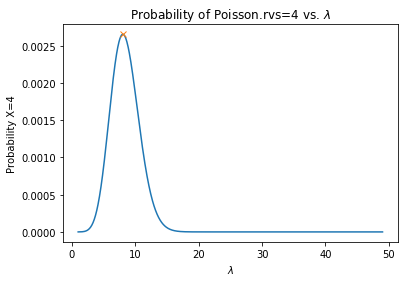

In [114]:
# Your code here
p = 1/4.
k = 4 #Observed Value of X

x = np.linspace(1,49,1000)
res = np.exp(-x)*x**k/np.math.factorial(k)* sp.special.binom(50,x)* (p)**x * (1-p)**(50-x)
for i in range(1,len(res)-1):
    if (res[i]-res[i+1])>=0 and (res[i]-res[i-1])>=0:
        max_i = i
print("the result is", x[max_i])

plt.plot(x,res, x[max_i], res[max_i],'x') #Plots the pmf as a function of lambda

plt.title('Probability of Poisson.rvs=4 vs. $\lambda$')
plt.ylabel('Probability X='+str(k))
plt.xlabel('$\lambda$')



__Answer:__ (Your answer here)
No, the MAP estimate is not the same as my ML estimate. Map is 8.06, while ML is 4

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 3</SPAN>**

## Confidence Intervals:

When we talk about confidence intervals, it's important to review the difference between two keywords: population and sample. If you've ever watched news stations during a campaign season, you'll notice they often show percentages. Joe Smith is running for governor of Illinois and "the percentage of voters who support Joe Smith is 47%." Where does this number come from? It would be foolhardy for the news station to go out and try to poll every single eligible voter in the state of Illinois. Instead they select only a fraction of the eligible voters and project those results to indicate the entire state. In this example, the population would be all of the eligible voters in Illinois, and the sample would be those that the news station polled. 

When we do confidence intervals, like the news station we are looking to estimate some measure of the population by only looking at a small sample of the population. Often hidden in the news station reports are the intervals and confidence levels of their percentage. A more exact statement of candidate Joe would be "the percentage of voters who support Joe Smith is 47% with polling accuracy $\pm$2% and a confidence of 95%." This means that the confidence interval has width 4% and, before the poll was taken, based on the sample size, there was at least a 95% probability that the confidence interval would contain the true percentage.

From a mathematical standpoint, the confidence interval is backed up by the Chebychev inequality. A proof of this is given in your ECE 313 textbook in Section 2.9. For $a>1$ we find, for confidence level $1-\frac{1}{a^2}$ that the width of the confidence interval
can be taken to be $\frac{a}{\sqrt{n}}$:

$P\left\{p \in \left(\hat{p}-\frac{a}{2\sqrt{n}},\hat{p}+\frac{a}{2\sqrt{n}}\right)\right\}\ge 1-\frac{1}{a^2}$

<br>**<SPAN style="BACKGROUND-COLOR: #C0C0C0">Problem 4:</SPAN>** Let's take another look at our voting scenario. It's an election season and Joe Smith is running for governor. Let's assume there are 100,000 eligible voters in Illinois (there are really about 7.2 million, but that's a bit too large to deal with at the moment), and assume that we have a record of each and every vote. Attached to this lab is a pickle file called voters.pkl which contains every person's response to whether they support Joe Smith (1 means support and 0 means does not support).   Your job is to become the news reporter and determine how much support Joe Smith has, based on sampling a subset of the voters. 
<ol>
    <li> Suppose your budget and time will allow you to sample 4,000 voters selected at random.   Plot the half-width of the confidence
    interval versus the confidence level, where the confidence level (in percent) is $(100)*(1-\frac{1}{a^2}),$  and the confidence
    level ranges from 75% to 99%. In
    particular, what are the half-widths for confidence levels 80% and 90%?</li>
    <li> Load the data file into the array.  What fraction of the voters support Joe Smith?   (Your answer here is the *true fraction* and is
    entirely determined by the data given.   There is nothing random about it. But it requires you to know how all 100,000 voters responded.)  
    <li> Now simulate what happens when you estimate the true fraction by sampling 4,000 voters at random, and calculating the fraction of
    sampled voters that support Joe Smith.  To do this, use np.random.shuffle(x) to shuffle the array x of votes and then simply average the
    first 4,000 entries of the suffled array to obtain the estimate.   The confidence interval for a given confidence level is centered
    at the estimate you found, with the half-width depending on the confidence level as in part 1.
    <li> Perform the simulation of the previous part 100 times and plot a histogram of the 100 estimates. What fraction of the estimates are within
    the 80% confidence interval half-width of the true parameter?   What fraction are within the 90% confidence interval half-width.
    Do the 80% confidence intervals capture the true fraction about 80% of the time?
</ol>

the half-widths for confidence levels 80% is 0.017677669529663688
the half-widths for confidence levels 90% is 0.025


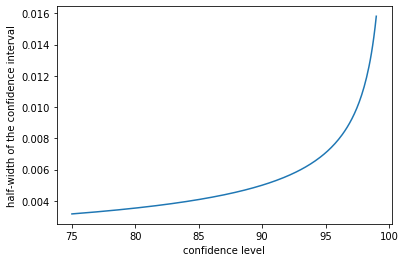

In [115]:
######## Your code here ######

filepath = 'voters.pkl'  # Load 0-1 vector for parts 2-4
f = open(filepath, 'rb')
x = pkl.load(f)
f.close()

n = 100000
def f(con_level,n):
    a = np.sqrt(1/(1-con_level/100))
    #print(a)
    con_interval = a/np.sqrt(n)
    half_width = con_interval/2
    return half_width

con_level = np.linspace(75, 99, 251)
plt.plot(con_level, f(con_level,n))
plt.xlabel("confidence level")
plt.ylabel("half-width of the confidence interval")

print("the half-widths for confidence levels 80% is",f(80,4000))
print("the half-widths for confidence levels 90% is",f(90,4000))

In [116]:
count = 0
tot = 0
for i in x:
    tot += 1
    if i == 1:
        count += 1
p2 = count/tot
p2

0.5202

In [117]:
x_sam = x
np.random.shuffle(x_sam)
x_sam = x_sam[:4000]
count = 0
tot = 0
for i in x_sam:
    tot += 1
    if i == 1:
        count += 1
p3 = count/tot
p3

0.51375

the fraction within the 80% confidence interval half-width is 0.96
the fraction within the 90% confidence interval half-width is 1.0


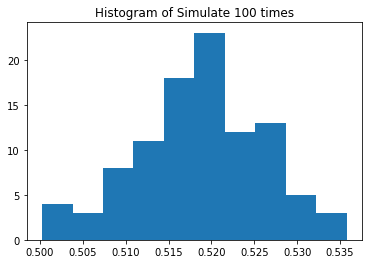

In [124]:
p4 = []
for n in range(100):
    x_sam = x
    np.random.shuffle(x_sam)
    x_sam = x_sam[:4000]
    count = 0
    tot = 0
    for i in x_sam:
        tot += 1
        if i == 1:
            count += 1
    p4.append(count/tot)
    
plt.hist(p4)
plt.title('Histogram of Simulate 100 times')

count = 0
for i in p4:
    if i >= p2-f(80, 4000) and i <= p2+f(80, 4000):
        #print(p2, f(80), p2-f(80), p2+f(80))
        count += 1
        #print(i)
p_80 = count/100.
print("the fraction within the 80% confidence interval half-width is",p_80)

count = 0
for i in p4:
    if i >= p2-f(90, 4000) and i <= p2+f(90, 4000):
        count += 1
p_90 = count/100.
print("the fraction within the 90% confidence interval half-width is",p_90)

__Answer:__ (Your answer here)

The 80% confidence intervals capture the true fraction about 96% of the time

**<SPAN style="BACKGROUND-COLOR: #C0C0C0">End of Problem 4</SPAN>**

## Lab Questions:

Make sure to complete all lab questions 1-4 for this weeks lab.

<div class="alert alert-block alert-warning"> 
## Academic Integrity Statement ##

By submitting the lab with this statement, you declare you have written up the lab entirely by yourself, including both code and markdown cells. You also agree that you should not share your code with anyone else. Any violation of the academic integrity requirement may cause an academic integrity report to be filed that could go into your student record. See <a href="https://provost.illinois.edu/policies/policies/academic-integrity/students-quick-reference-guide-to-academic-integrity/">Students' Quick Reference Guide to Academic Integrity</a> for more information. 